In [1]:
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import bilby
import h5py
from scipy.integrate import quad
import astropy.units as u
from astropy.cosmology import z_at_value

19:26 bilby INFO    : Running bilby version: 0.5.2:


The Luminosity distance for this model is

$$d_L^{\rm GW} = d_L ^{\frac{D-2}{2}}$$

Taken from https://arxiv.org/pdf/1811.00364.pdf, https://arxiv.org/abs/0709.0003, https://arxiv.org/abs/1801.08160 using the assumption that $R_c \ll d_l$. GR recovered for $D=4$

In [2]:
def gw_luminosity_distance(z,cosmology,D):
    dl_cosmo = cosmology.luminosity_distance(z).value
    return dl_cosmo**((D-2)/2)

In [3]:
def selection_effect(d_max,z_guess,pdet,cosmology,D):
    
    #funct_to_solve = lambda z: gw_luminosity_distance(z,cosmology,D)-d_max
    
    #zcrit=0 
    #while zcrit==0:
    #    zcrit=fsolve(funct_to_solve,z_guess, xtol=0.001)[0] # Initial solution of z_guess
    
    #print(d_max**(2/(D-2)))
    zcrit = z_at_value(cosmology.luminosity_distance,(d_max**(2/(D-2)))*u.Mpc)
    
    z_array=np.logspace(-6,np.log10(zcrit),1000)
    
    dl_gw = gw_luminosity_distance(z_array,cosmology,D)
    prior = cosmology.differential_comoving_volume(z_array).value/(1+z_array)

    return np.trapz(pdet(dl_gw)*prior,z_array)

In [4]:
class modGR_likelihood(bilby.Likelihood):

    def __init__(self,gkde_posterior,z_samples,pdet,d_max):

        super().__init__(parameters={})
        self.gkde_posterior=gkde_posterior
        self.pdet=pdet
        self.d_max=d_max
        self.z_samples=z_samples
        

    def log_likelihood(self):
        """ Returns the log likelihood
        """
                
        
        # Cosmo parameters
        H0 = self.parameters['H0']
        Om0 = self.parameters['Om0']
        
        # Deviation parameters
        D = self.parameters['D']
        
        cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
        
        N_events = len(self.gkde_posterior)
        
        numerator=1
        sel_effect=1
        
        for i in range(N_events):
        
            dgws = gw_luminosity_distance(self.z_samples[i],cosmo,D)

            sel_effect *= selection_effect(self.d_max[i],np.mean(self.z_samples[i]),self.pdet[i],cosmo,D)
            
            evals=self.gkde_posterior[i](dgws)
            evals[evals<=1e-6]=1e-100
            
            if sel_effect==0: 
                print(self.parameters)
            numerator *= np.sum(evals*cosmo.differential_comoving_volume(
                self.z_samples[i]).value/((dgws**2)*(1+self.z_samples[i])))

        return np.log(numerator)-np.log(sel_effect)
        
        
        


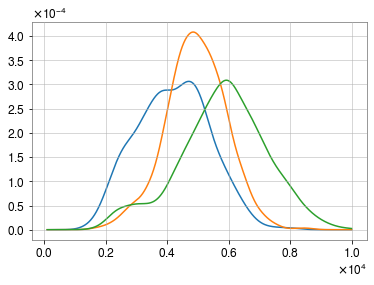

In [6]:
for wave in ['SEONBR','IMRPhenom','NRSur']:

    data = np.genfromtxt('LOS_fit_'+wave+'_1e-3deg2.txt')
    interp_pos = interp1d(data[:,0],data[:,1],bounds_error=False,fill_value=0)
    plt.plot(data[:,0],interp_pos(data[:,0]),label='interpolation')

##  analysis

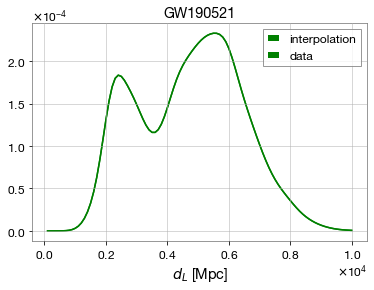

In [19]:
#provide here the list of events you want to analyse 
events = ['GW190521']
mode = 'planck'
wave = 'NRSur'
outdir = wave+'/planck_mass_prior_'+mode+'_GW190521'

pos_inter_likeli = []
# Below load and fit with an interp1d the posterior of luminosity distance provided by LVC. 
# Note: please, do not remove the original d**2 prior. It is taken into account in the likelihood

for event in events:
    
    if event == 'GW170817':
        data = np.genfromtxt('high_spin_PhenomPNRT_posterior_samples.dat',names=True)
        lum_distance_samples = data['luminosity_distance_Mpc']
        plt.figure()
        
        gkde_pos = gaussian_kde(lum_distance_samples)
        dprox = np.linspace(np.min(lum_distance_samples),np.max(lum_distance_samples),1000)
        interp_pos = interp1d(dprox,gkde_pos(dprox),bounds_error=False,fill_value=0)

        pos_inter_likeli.append(interp_pos)

        _ = plt.hist(gkde_pos.resample(1000)[0],bins='auto',label='gkde samples',density=True)
        _ = plt.hist(lum_distance_samples,bins='auto',label='actual samples',color='orange',density=True)
        plt.plot(dprox,interp_pos(dprox),label='interpolation',color='green')
        plt.title(event)
        
    elif event == 'GW190521':
        plt.figure()
        data = np.genfromtxt('LOS_fit_'+wave+'_1e-3deg2.txt')
        interp_pos = interp1d(data[:,0],data[:,1],bounds_error=False,fill_value=0)
        pos_inter_likeli.append(interp_pos)
        plt.plot(data[:,0],interp_pos(data[:,0]),label='interpolation',color='green')
        plt.plot(data[:,0],data[:,1],label='data',color='green')
        plt.title(event)
        
    
    plt.legend()
    plt.xlabel(r'$d_L$ [Mpc]')

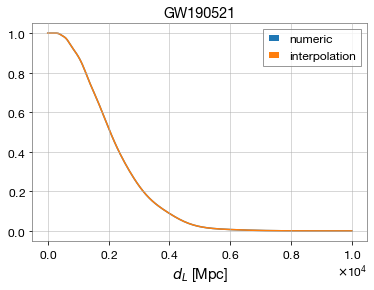

In [20]:
# Here it loads and and interpolate the precomputed detection probabilities

det_interp_likeli = []
d_max_likeli = []

for event in events:
    
    if event == 'GW170817':
        data = np.genfromtxt('det_prob_BNS.dat')
        d_max_likeli.append(200)
        data[:,0]*=0.35


    elif event == 'GW190521':
        data = np.genfromtxt('det_prob_BBH.dat')
        d_max_likeli.append(1e4)
                
    plt.figure()
    plt.title(event)

    plt.plot(data[:,0],data[:,1],label='numeric')
    interpolation_pdet = interp1d(data[:,0],data[:,1],bounds_error=False,fill_value=0)
    
    det_interp_likeli.append(interpolation_pdet)
    
    plt.plot(data[:,0],interpolation_pdet(data[:,0]),label='interpolation')
    plt.legend()
    plt.xlabel(r'$d_L$ [Mpc]')

In [21]:
d_max_likeli

[10000.0]

In [22]:
z_em_likeli = []

for event in events:
    
    if event == 'GW170817':
        c=299792.458
        
        mu = np.array([3327/c, +310.0/c])
        sig = np.array([72/c,150/c])
        
        mu_tot= mu[0]-mu[1]
        sig_tot=np.sqrt(np.sum(sig**2))
        
        z_em_likeli.append(0.010033618884026258+0.0005445973324705001*np.random.randn(500))
        
    elif event == 'GW190521':
        z_em_likeli.append(0.438)

likeli = modGR_likelihood(pos_inter_likeli,z_em_likeli,det_interp_likeli,d_max_likeli)


priors = {}

priors = {}

if mode == 'planck':
    priors['H0']=bilby.core.prior.Gaussian(mu=67.66,sigma=0.42,name='H0',latex_label='$H_0$')
    priors['Om0']=bilby.core.prior.Gaussian(mu=0.3111,sigma=0.0056,name='Om0',latex_label='$\Omega_{m,0}$')
    
elif mode == 'all':
    priors['H0']=bilby.core.prior.Uniform(minimum=20,maximum=300,name='H0',latex_label='$H_0$')
    priors['Om0']=bilby.core.prior.Uniform(minimum=0.2,maximum=1.0,name='Om0',latex_label='$\Omega_{m,0}$')

priors['D']=bilby.core.prior.Uniform(minimum=3.5,maximum=5,name='D',latex_label='$D$')

In [23]:
result=bilby.run_sampler(likelihood=likeli, priors=priors, outdir=outdir, 
                         sampler='emcee',nwalkers=10,iterations=2000)

18:47 bilby INFO    : Running for label 'label', output will be saved to 'NRSur/planck_mass_prior_planck_GW190521'
18:47 bilby INFO    : Search parameters:
18:47 bilby INFO    :   H0 = Gaussian(mu=67.66, sigma=0.42, name='H0', latex_label='$H_0$', unit=None, boundary=None)
18:47 bilby INFO    :   Om0 = Gaussian(mu=0.3111, sigma=0.0056, name='Om0', latex_label='$\\Omega_{m,0}$', unit=None, boundary=None)
18:47 bilby INFO    :   D = Uniform(minimum=3.5, maximum=5, name='D', latex_label='$D$', unit=None, boundary=None)
18:47 bilby INFO    : Single likelihood evaluation took 2.458e-02 s
18:47 bilby WARNING : Supplied argument 'npool' not an argument of 'Emcee', removing.
18:47 bilby INFO    : Using sampler Emcee with kwargs {'nwalkers': 10, 'a': 2, 'args': [], 'kwargs': {}, 'postargs': None, 'pool': None, 'live_dangerously': False, 'runtime_sortingfn': None, 'lnprob0': None, 'rstate0': None, 'blobs0': None, 'iterations': 2000, 'thin': 1, 'storechain': True, 'mh_proposal': None}
100%|██████

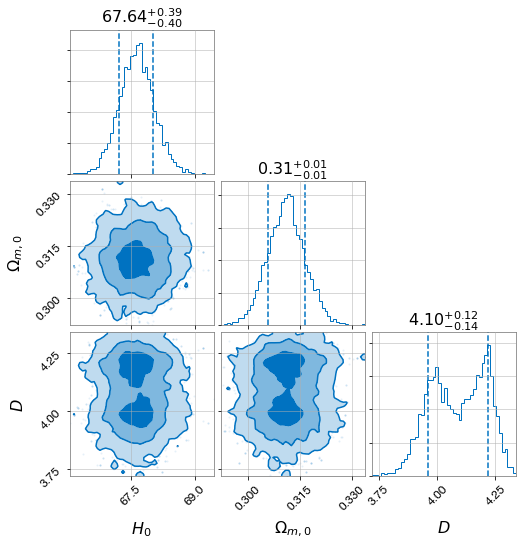

In [24]:
result.plot_corner()

In [22]:
gw_luminosity_distance(1.5,FlatLambdaCDM(H0=120,Om0=0.3),D=4.4)

36683.65738765403

In [24]:
(selection_effect(200,0.01,det_interp_likeli[1],FlatLambdaCDM(H0=140,Om0=0.3),D=4.4)/
selection_effect(200,0.01,det_interp_likeli[1],FlatLambdaCDM(H0=70,Om0=0.3),D=4.0))

0.07227629289296378